Spectral Ratio AFTER analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, spectrogram
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
 # Smoothing function
def smooth_curve_simple(x, y, points=300):
    x_new = np.linspace(min(x), max(x), points)
    spl = make_interp_spline(x, y, k=2)
    y_new = spl(x_new)
    return x_new, y_new

In [4]:
# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define channels and sampling frequency
channels = ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
sampling_frequency = 256


In [10]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA
from scipy.fft import fft
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

channels = ['RAW_TP9','RAW_TP10']
time_power = {}
time_intervals = ['First 33%', 'Middle 33%', 'Last 33%']
    # Define frequency bands
band_ranges = {
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Delta': (0.5, 4),
        'Beta': (13, 30),
        'Gamma': (30, 45)
    }

# Filter the data
def analyse_EEG(file_path):
    df = pd.read_csv(file_path)
    df = df[channels]
    df = df.dropna()
    filtered_df = df.copy()
    for channel in channels:
        filtered_df[channel] = bandpass_filter(df[channel], 0.5, 45, sampling_frequency)

    # Handle NaNs and Infinite values
    filtered_df = filtered_df.fillna(filtered_df.mean())
    filtered_df = filtered_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Apply ICA
    ica = FastICA(n_components=4, random_state=97, max_iter=800)
    ICAfit = ica.fit_transform(filtered_df[channels])

    # Convert the ICA components back to the original space
    df_cleaned = df.copy()
    df_cleaned[channels] = ica.inverse_transform(ICAfit)


    # Fourier transform for power spectra
    frequencies = np.fft.fftfreq(df_cleaned.shape[0], 1/sampling_frequency)
    band_power = {}

    for channel in channels:
        fft_values = fft(df_cleaned[channel].values)
        power_spectrum = np.abs(fft_values)**2
        band_power[channel] = {}
        for band, (low_freq, high_freq) in band_ranges.items():
            idx_band = np.where((frequencies >= low_freq) & (frequencies <= high_freq))
            avg_power = np.mean(power_spectrum[idx_band])
            band_power[channel][band] = avg_power

    # Temporal analysis
    split_indices = np.array_split(df_cleaned.index, 3)

    for i, interval in enumerate(time_intervals):
        time_power[interval] = {}
        df_interval = df_cleaned.loc[split_indices[i]]
        interval_power_spectra = {}
        for channel in channels:
            fft_values = fft(df_interval[channel].values)
            power_spectrum = np.abs(fft_values)**2
            interval_power_spectra[channel] = power_spectrum

        for channel in channels:
            time_power[interval][channel] = {}
            for band, (low_freq, high_freq) in band_ranges.items():
                idx_band = np.where((frequencies >= low_freq) & (frequencies <= high_freq))
                avg_power = np.mean(interval_power_spectra[channel][idx_band])
                time_power[interval][channel][band] = avg_power

    # Attention metrics
    attention_metrics = {}
    for interval in time_intervals:
        attention_metrics[interval] = {}
        for channel in channels:
            theta_power = time_power[interval][channel]['Theta']
            beta_power = time_power[interval][channel]['Beta']
            alpha_power = time_power[interval][channel]['Alpha']
            gamma_power = time_power[interval][channel]['Gamma']
            tbr = theta_power / beta_power if beta_power != 0 else 0
            attention_metrics[interval][channel] = {
                'Theta/Beta Ratio': tbr,
                'Alpha Power': alpha_power,
                'Gamma Power': gamma_power
            }

    # Aggregate metrics
    aggregated_metrics = {}
    for interval in time_intervals:
        aggregated_metrics[interval] = {
            'Theta/Beta Ratio': 0,
            'Alpha Power': 0,
            'Gamma Power': 0
        }
        for channel in channels:
            aggregated_metrics[interval]['Theta/Beta Ratio'] += attention_metrics[interval][channel]['Theta/Beta Ratio']
            aggregated_metrics[interval]['Alpha Power'] += attention_metrics[interval][channel]['Alpha Power']
            aggregated_metrics[interval]['Gamma Power'] += attention_metrics[interval][channel]['Gamma Power']

        aggregated_metrics[interval]['Theta/Beta Ratio'] /= len(channels)
        aggregated_metrics[interval]['Alpha Power'] /= len(channels)
        aggregated_metrics[interval]['Gamma Power'] /= len(channels)

    # Update the aggregated metrics
    for interval in time_intervals:
        theta_power = np.mean([time_power[interval][channel]['Theta'] for channel in channels])
        beta_power = np.mean([time_power[interval][channel]['Beta'] for channel in channels])
        alpha_power = np.mean([time_power[interval][channel]['Alpha'] for channel in channels])
        delta_power = np.mean([time_power[interval][channel]['Delta'] for channel in channels])
        gamma_power = np.mean([time_power[interval][channel]['Gamma'] for channel in channels])

        aggregated_metrics[interval]['Theta/Beta Ratio'] = theta_power / (beta_power + 1e-6)
        aggregated_metrics[interval]['Theta/Alpha Ratio'] = theta_power / (alpha_power + 1e-6)
        aggregated_metrics[interval]['Delta/Theta Ratio'] = delta_power / (theta_power + 1e-6)
        aggregated_metrics[interval]['Theta/Gamma Ratio'] = theta_power / (gamma_power + 1e-6)

    return {
        'band_power': band_power,
        'time_power': time_power,
        'attention_metrics': attention_metrics,
        'aggregated_metrics': aggregated_metrics
    }

# Loop over data for all 15 people
# 2. Generate results for the "Before" attention test
all_results_before = {}
for i in range(1, 16):  # 15 people
    EEG = f"/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/After/{i}_After.csv"
    all_results_after[f"person_{i}"] = analyse_EEG(EEG)


In [17]:
df=pd.DataFrame(all_results_after)
df

,person_1,person_2,person_3,person_4,person_5,person_6,person_7,person_8,person_9,person_10,person_11,person_12,person_13,person_14,person_15
band_power,"{'RAW_TP9': {'Theta': 767681422.5612592, 'Alph...","{'RAW_TP9': {'Theta': 8354942100.653053, 'Alph...","{'RAW_TP9': {'Theta': 775625839.8942695, 'Alph...","{'RAW_TP9': {'Theta': 2078851197.7780943, 'Alp...","{'RAW_TP9': {'Theta': 10635978562.685555, 'Alp...","{'RAW_TP9': {'Theta': 1704867664.1863952, 'Alp...","{'RAW_TP9': {'Theta': 986324821.3839369, 'Alph...","{'RAW_TP9': {'Theta': 417136153.4395344, 'Alph...","{'RAW_TP9': {'Theta': 307262270.0583766, 'Alph...","{'RAW_TP9': {'Theta': 907273217.7769552, 'Alph...","{'RAW_TP9': {'Theta': 2736637494.7540016, 'Alp...","{'RAW_TP9': {'Theta': 3660735349.128108, 'Alph...","{'RAW_TP9': {'Theta': 1193213080.4616687, 'Alp...","{'RAW_TP9': {'Theta': 77166070461.26102, 'Alph...","{'RAW_TP9': {'Theta': 611112185.4832985, 'Alph..."
time_power,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...,{'First 33%': {'RAW_TP9': {'Theta': 21178026.4...
attention_metrics,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...,{'First 33%': {'RAW_TP9': {'Theta/Beta Ratio':...
aggregated_metrics,{'First 33%': {'Theta/Beta Ratio': 8.303881437...,{'First 33%': {'Theta/Beta Ratio': 21.73253128...,{'First 33%': {'Theta/Beta Ratio': 48.62383878...,{'First 33%': {'Theta/Beta Ratio': 8.257061644...,{'First 33%': {'Theta/Beta Ratio': 17.96349516...,{'First 33%': {'Theta/Beta Ratio': 7.001705608...,{'First 33%': {'Theta/Beta Ratio': 28.00026440...,{'First 33%': {'Theta/Beta Ratio': 16.48846747...,{'First 33%': {'Theta/Beta Ratio': 17.04523608...,{'First 33%': {'Theta/Beta Ratio': 2.426036794...,{'First 33%': {'Theta/Beta Ratio': 8.689458838...,{'First 33%': {'Theta/Beta Ratio': 59.38824794...,{'First 33%': {'Theta/Beta Ratio': 7.715343204...,{'First 33%': {'Theta/Beta Ratio': 108.0235696...,{'First 33%': {'Theta/Beta Ratio': 12.00075855...


In [9]:
#Frontal
df.to_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_results_afterfrontals.csv")

In [18]:
# temporal
df.to_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_results_aftertemporal.csv")

In [30]:
df_frontal_after = pd.read_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_results_afterfrontals.csv")

In [31]:
df_temporal_after = pd.read_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_results_aftertemporal.csv")

In [32]:
# Extracting aggregated metrics for all participants from the new temporal data
all_data_temporal_after = {}
for col in df_temporal_after.columns[1:]:  # Skipping the 'Unnamed: 0' column
    metrics = df_temporal_after.loc[3, col]
    if isinstance(metrics, str):
        metrics = ast.literal_eval(metrics)
    all_data_temporal_after[col] = {ratio: [metrics[interval][ratio] for interval in time_intervals] for ratio in ratios}

# Calculate average ratios across all participants for the new temporal data
avg_data_temporal_after = {}
for ratio in ratios:
    avg_data_temporal_after[ratio] = [np.mean([all_data_temporal_after[person][ratio][i] for person in all_data_temporal_after]) for i in range(3)]

# Calculate shifts for the new temporal data
shifts_temporal_after = {ratio: calculate_shift(avg_data_temporal_after[ratio]) for ratio in ratios}

# Prepare data for table
data_table_temporal_after = {
    'Brain Region': ['Temporal', 'Temporal'],
    'Stages': ['Second 30%', 'Third 30%'],
    'TBR': [shifts_temporal_after['Theta/Beta Ratio'][0], shifts_temporal_after['Theta/Beta Ratio'][1]],
    'TAR': [shifts_temporal_after['Theta/Alpha Ratio'][0], shifts_temporal_after['Theta/Alpha Ratio'][1]],
    'DTR': [shifts_temporal_after['Delta/Theta Ratio'][0], shifts_temporal_after['Delta/Theta Ratio'][1]],
    'TGR': [shifts_temporal_after['Theta/Gamma Ratio'][0], shifts_temporal_after['Theta/Gamma Ratio'][1]],
}

# Convert to DataFrame
df_shifts_temporal_after = pd.DataFrame(data_table_temporal_after)
df_shifts_temporal_after


,Brain Region,Stages,TBR,TAR,DTR,TGR
0,Temporal,Second 30%,-48.789186,-15.225643,35.373364,227.884255
1,Temporal,Third 30%,85.000968,5.631583,-6.957272,-34.681925


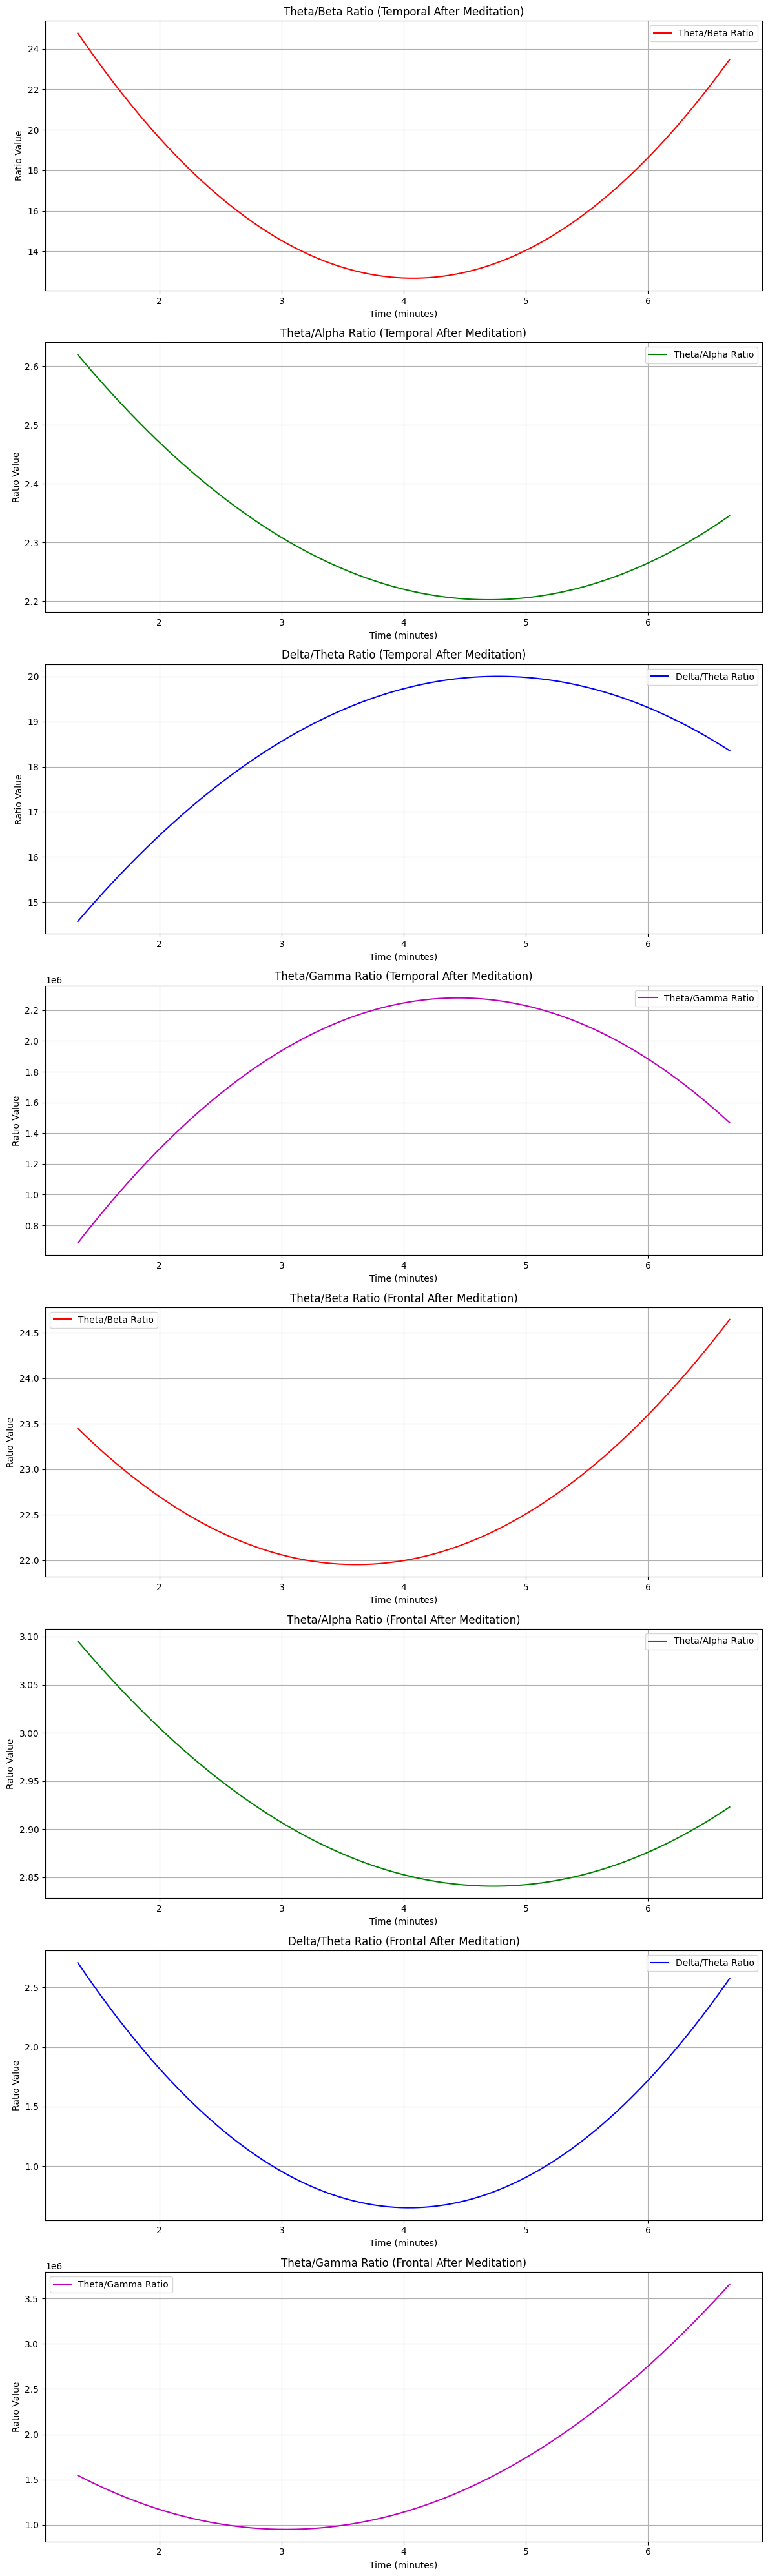

In [36]:

# Extracting aggregated metrics for all participants from the frontal data
all_data_frontal_after = {}
for col in df_frontal_after.columns[1:]:  # Skipping the 'Unnamed: 0' column
    metrics = df_frontal_after.loc[3, col]
    if isinstance(metrics, str):
        metrics = ast.literal_eval(metrics)
    all_data_frontal_after[col] = {ratio: [metrics[interval][ratio] for interval in time_intervals] for ratio in ratios}
# Define the xnew variable for interpolation
xnew = np.linspace(min(midpoints), max(midpoints), 300)

# Calculate average ratios across all participants for the frontal data
avg_data_frontal_after = {}
for ratio in ratios:
    avg_data_frontal_after[ratio] = [np.mean([all_data_frontal_after[person][ratio][i] for person in all_data_frontal_after]) for i in range(3)]

# Plotting separate curves for each ratio for temporal and frontal data
fig, axs = plt.subplots(8, 1, figsize=(12, 40))

# Temporal plotting
for idx, (ratio, color) in enumerate(zip(ratios, ['r', 'g', 'b', 'm'])):
    spline = make_interp_spline(midpoints, avg_data_temporal_after[ratio], k=2)
    ynew = spline(xnew)
    axs[idx].plot(xnew, ynew, label=ratio, color=color)
    axs[idx].set_title(ratio + " (Temporal After Meditation)")
    axs[idx].set_xlabel("Time (minutes)")
    axs[idx].set_ylabel("Ratio Value")
    axs[idx].legend()
    axs[idx].grid(True)

# Frontal plotting
for idx, (ratio, color) in enumerate(zip(ratios, ['r', 'g', 'b', 'm'])):
    spline = make_interp_spline(midpoints, avg_data_frontal_after[ratio], k=2)
    ynew = spline(xnew)
    axs[idx + 4].plot(xnew, ynew, label=ratio, color=color)
    axs[idx + 4].set_title(ratio + " (Frontal After Meditation)")
    axs[idx + 4].set_xlabel("Time (minutes)")
    axs[idx + 4].set_ylabel("Ratio Value")
    axs[idx + 4].legend()
    axs[idx + 4].grid(True)

plt.tight_layout()
plt.show()


# Temporal

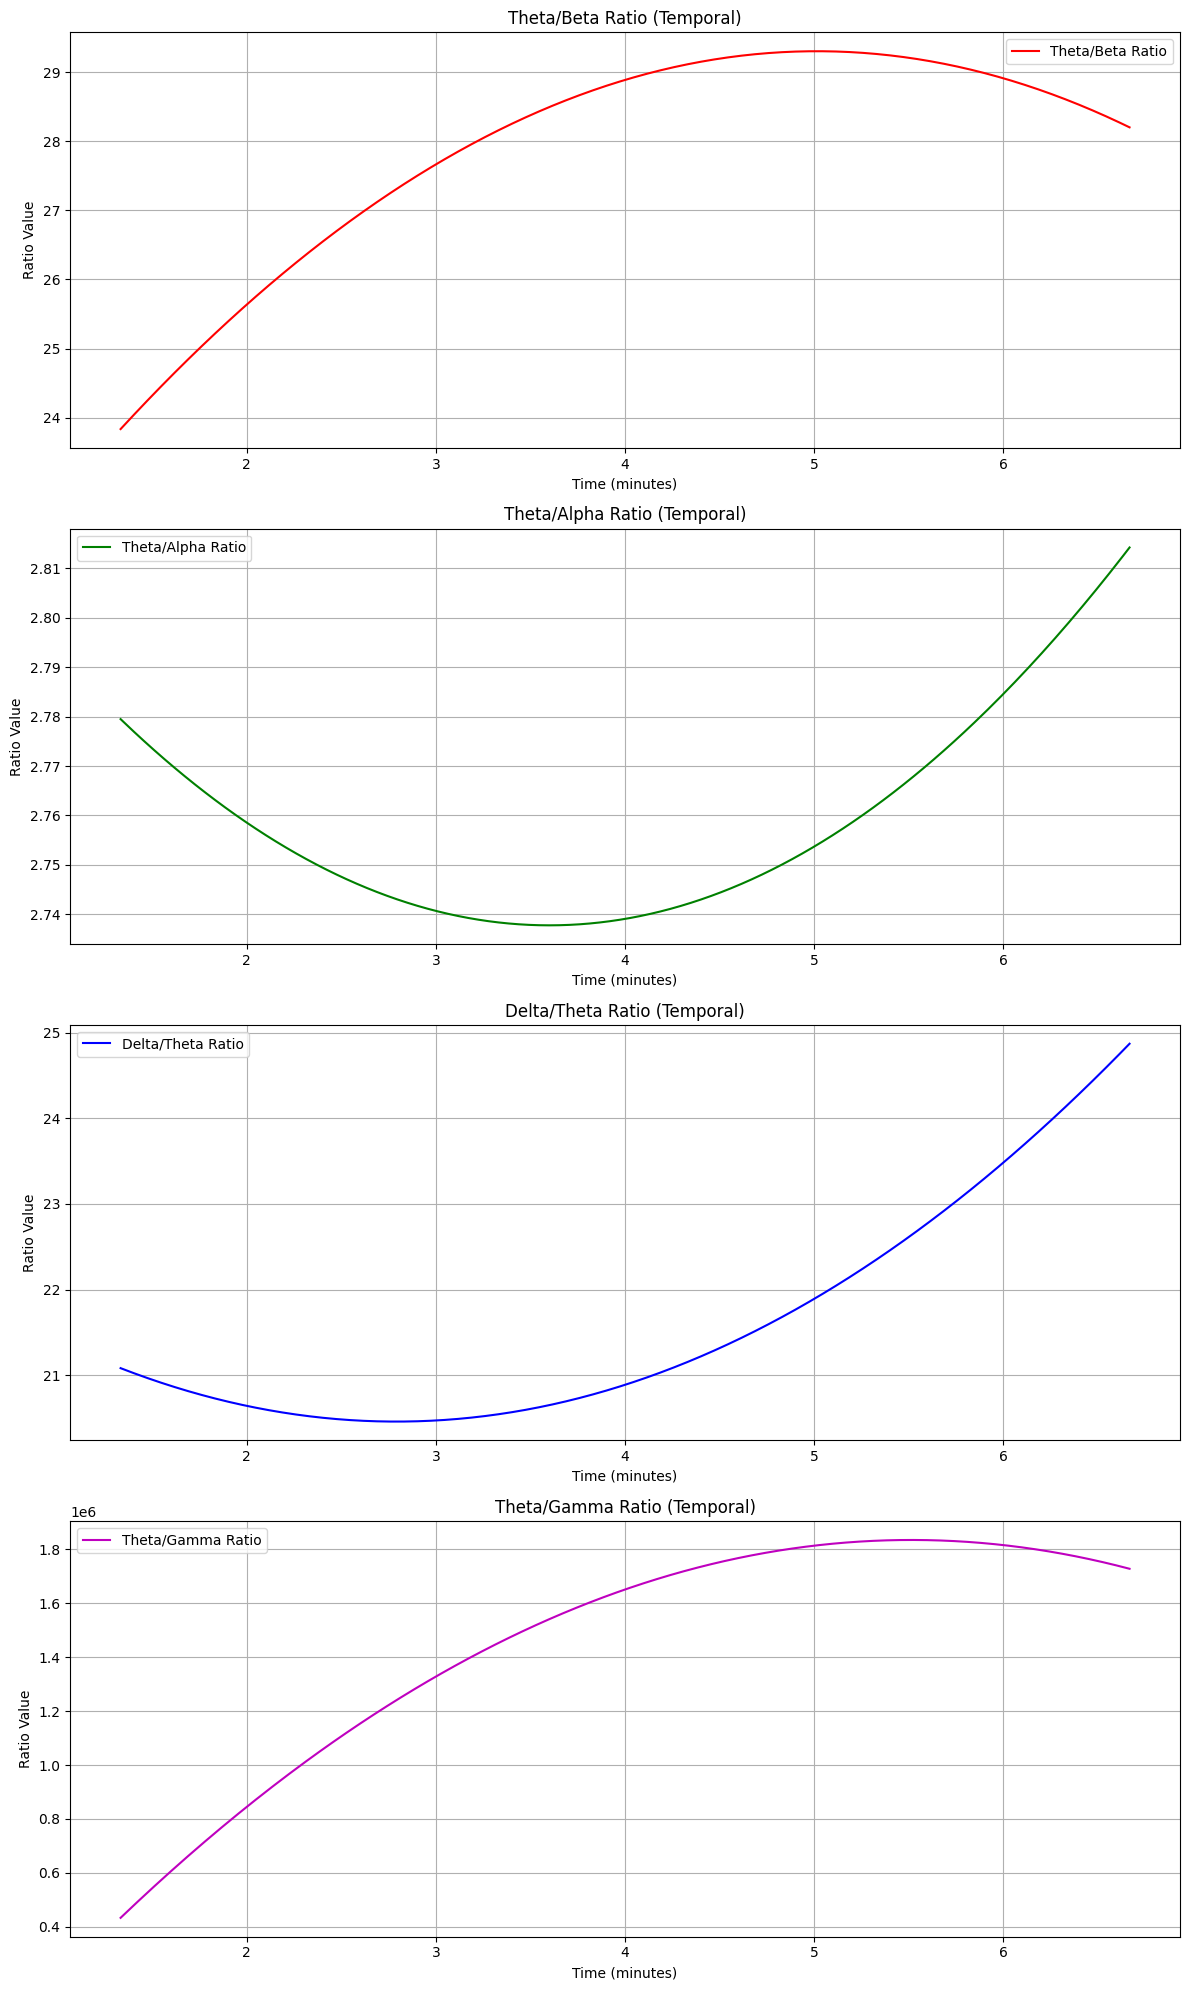

In [ ]:
# Plot
# Extracting aggregated metrics for all participants from temporal data
import ast
ratios = ['Theta/Beta Ratio', 'Theta/Alpha Ratio', 'Delta/Theta Ratio', 'Theta/Gamma Ratio']
time_intervals = ['First 33%', 'Middle 33%', 'Last 33%']
midpoints = [8/3 * 0.5, 8/3 * 1.5, 8/3 * 2.5]  # Representing the midpoints of the time intervals for an 8-minute session
# Adjusted spline interpolation with the new time points
xnew = np.linspace(min(midpoints), max(midpoints), 300)
avg_data_smooth_frontal = {}


df_temporal = pd.read_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_results_beforetemporal.csv")
# Extracting aggregated metrics for all participants from temporal data
all_data_temporal = {}

for col in df_temporal.columns[1:]:  # Skipping the 'Unnamed: 0' column
    metrics = df_temporal.loc[3, col]
    if isinstance(metrics, str):  # Check if it's a serialized string
        metrics = ast.literal_eval(metrics)
    all_data_temporal[col] = {ratio: [metrics[interval][ratio] for interval in time_intervals] for ratio in ratios}

# Calculate average ratios across all participants for temporal data
avg_data_temporal = {}
for ratio in ratios:
    avg_data_temporal[ratio] = [np.mean([all_data_temporal[person][ratio][i] for person in all_data_temporal]) for i in range(3)]

# Plotting separate curves for each ratio for temporal data
fig, axs = plt.subplots(4, 1, figsize=(12, 20))

for idx, (ratio, color) in enumerate(zip(ratios, ['r', 'g', 'b', 'm'])):
    spline = make_interp_spline(midpoints, avg_data_temporal[ratio], k=2)
    ynew = spline(xnew)
    avg_data_smooth_frontal[ratio] = ynew
    axs[idx].plot(xnew, ynew, label=ratio, color=color)
    axs[idx].set_title(ratio + " (Temporal)")
    axs[idx].set_xlabel("Time (minutes)")
    axs[idx].set_ylabel("Ratio Value")
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()
plt.show()

# Frontal

In [ ]:
# Frontal % shift
df_frontal = pd.read_csv("/content/drive/MyDrive/01ExperimentsEEGR232/EEGList/all_results_beforefrontals.csv")

# Extracting aggregated metrics for all participants from frontal data
all_data_frontal = {}

for col in df_frontal.columns[1:]:  # Skipping the 'Unnamed: 0' column
    metrics = df_frontal.loc[3, col]
    if isinstance(metrics, str):  # Check if it's a serialized string
        metrics = ast.literal_eval(metrics)
    all_data_frontal[col] = {ratio: [metrics[interval][ratio] for interval in time_intervals] for ratio in ratios}

# Calculate average ratios across all participants for frontal data
avg_data_frontal = {}
for ratio in ratios:
    avg_data_frontal[ratio] = [np.mean([all_data_frontal[person][ratio][i] for person in all_data_frontal]) for i in range(3)]

# Define function to calculate percentage shifts
def calculate_shift(data):
    return [
        (data[i + 1] - data[i]) / data[i] * 100 for i in range(len(data) - 1)
    ]

# Calculate shifts for frontal data
shifts_frontal = {ratio: calculate_shift(avg_data_frontal[ratio]) for ratio in ratios}

# Prepare data for table
data_table = {
    'Brain Region': ['Frontal', 'Frontal'],
    'Stages': ['Analyzing challenges', 'Rehearsing solutions'],
    'TBR': [shifts_frontal['Theta/Beta Ratio'][0], shifts_frontal['Theta/Beta Ratio'][1]],
    'TAR': [shifts_frontal['Theta/Alpha Ratio'][0], shifts_frontal['Theta/Alpha Ratio'][1]],
    'DTR': [shifts_frontal['Delta/Theta Ratio'][0], shifts_frontal['Delta/Theta Ratio'][1]],
    'TGR': [shifts_frontal['Theta/Gamma Ratio'][0], shifts_frontal['Theta/Gamma Ratio'][1]],
}

# Convert to DataFrame
df_shifts = pd.DataFrame(data_table)
df_shifts


,Brain Region,Stages,TBR,TAR,DTR,TGR
0,Frontal,Analyzing challenges,-15.498238,-5.535172,-31.696815,-27.244572
1,Frontal,Rehearsing solutions,6.970926,0.228649,22.966382,-11.389541


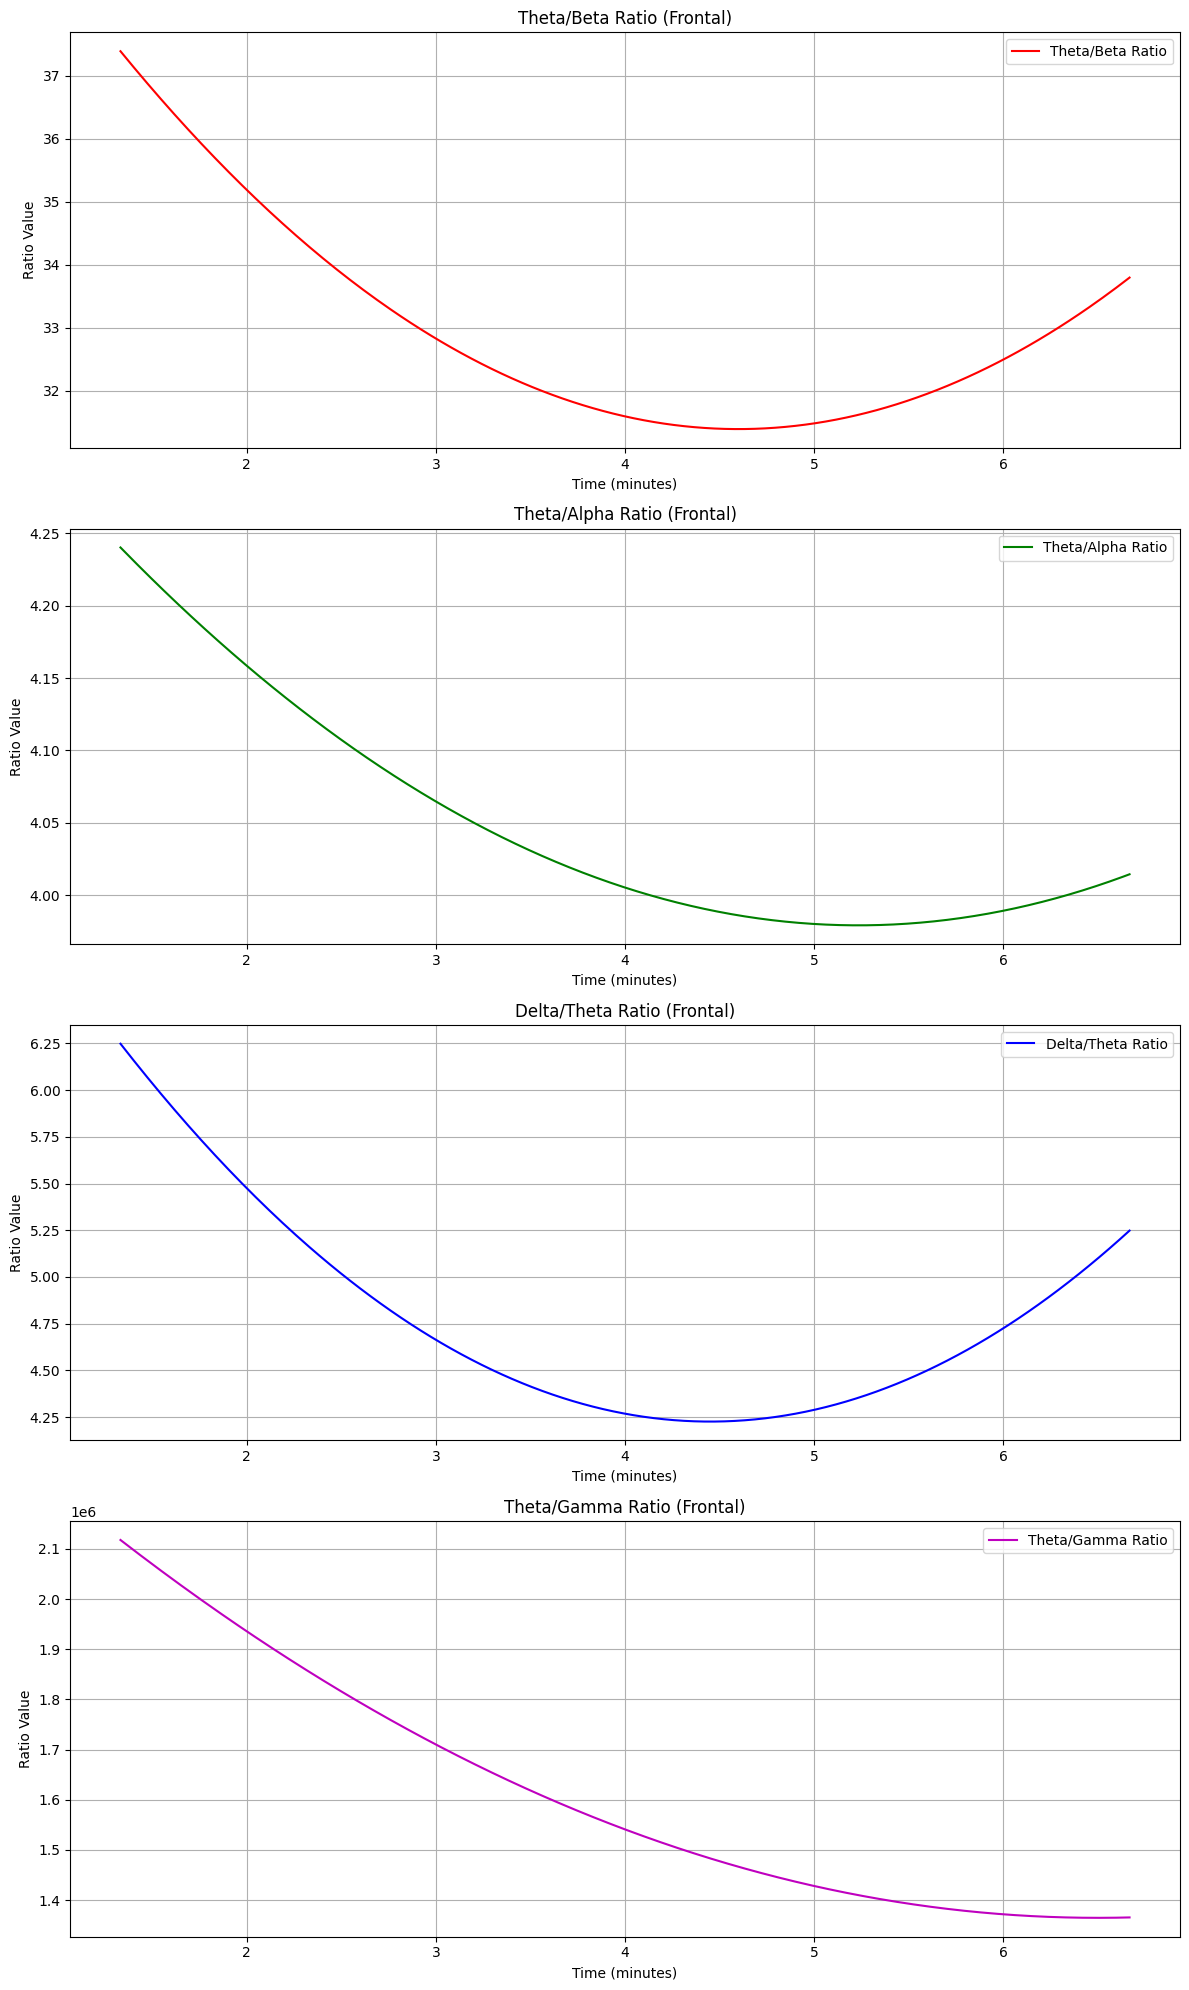

In [ ]:
# Frontal curves:
# Plotting separate curves for each ratio for frontal data
fig, axs = plt.subplots(4, 1, figsize=(12, 20))

for idx, (ratio, color) in enumerate(zip(ratios, ['r', 'g', 'b', 'm'])):
    spline = make_interp_spline(midpoints, avg_data_frontal[ratio], k=2)
    ynew = spline(xnew)
    avg_data_smooth_frontal[ratio] = ynew
    axs[idx].plot(xnew, ynew, label=ratio, color=color)
    axs[idx].set_title(ratio + " (Frontal)")
    axs[idx].set_xlabel("Time (minutes)")
    axs[idx].set_ylabel("Ratio Value")
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Consolidated code:
import pandas as pd
import ast


ratios = ['Theta/Beta Ratio', 'Theta/Alpha Ratio', 'Delta/Theta Ratio', 'Theta/Gamma Ratio']
time_intervals = ['First 33%', 'Middle 33%', 'Last 33%']

# Extracting aggregated metrics for all participants from frontal data
all_data_frontal = {}
for col in df_frontal.columns[1:]:
    metrics = df_frontal.loc[3, col]
    if isinstance(metrics, str):
        metrics = ast.literal_eval(metrics)
    all_data_frontal[col] = {ratio: [metrics[interval][ratio] for interval in time_intervals] for ratio in ratios}

# Calculate average ratios across all participants for frontal data
avg_data_frontal = {}
for ratio in ratios:
    avg_data_frontal[ratio] = [np.mean([all_data_frontal[person][ratio][i] for person in all_data_frontal]) for i in range(3)]

# Extracting aggregated metrics for all participants from temporal data
all_data_temporal = {}
for col in df_temporal.columns[1:]:
    metrics = df_temporal.loc[3, col]
    if isinstance(metrics, str):
        metrics = ast.literal_eval(metrics)
    all_data_temporal[col] = {ratio: [metrics[interval][ratio] for interval in time_intervals] for ratio in ratios}

# Calculate average ratios across all participants for temporal data
avg_data_temporal = {}
for ratio in ratios:
    avg_data_temporal[ratio] = [np.mean([all_data_temporal[person][ratio][i] for person in all_data_temporal]) for i in range(3)]

# Function to calculate percentage shifts
def calculate_shift(data):
    return [(data[i + 1] - data[i]) / data[i] * 100 for i in range(len(data) - 1)]

# Calculate shifts for frontal and temporal data
shifts_frontal = {ratio: calculate_shift(avg_data_frontal[ratio]) for ratio in ratios}
shifts_temporal = {ratio: calculate_shift(avg_data_temporal[ratio]) for ratio in ratios}

# Prepare data for table
data_table = {
    'Brain Region': ['Frontal', 'Frontal', 'Temporal', 'Temporal'],
    'Stages': ['Second 30%', 'Third 30%', 'Second 30%', 'Third 30%'],
    'TBR': [shifts_frontal['Theta/Beta Ratio'][0], shifts_frontal['Theta/Beta Ratio'][1], shifts_temporal['Theta/Beta Ratio'][0], shifts_temporal['Theta/Beta Ratio'][1]],
    'TAR': [shifts_frontal['Theta/Alpha Ratio'][0], shifts_frontal['Theta/Alpha Ratio'][1], shifts_temporal['Theta/Alpha Ratio'][0], shifts_temporal['Theta/Alpha Ratio'][1]],
    'DTR': [shifts_frontal['Delta/Theta Ratio'][0], shifts_frontal['Delta/Theta Ratio'][1], shifts_temporal['Delta/Theta Ratio'][0], shifts_temporal['Delta/Theta Ratio'][1]],
    'TGR': [shifts_frontal['Theta/Gamma Ratio'][0], shifts_frontal['Theta/Gamma Ratio'][1], shifts_temporal['Theta/Gamma Ratio'][0], shifts_temporal['Theta/Gamma Ratio'][1]],
}

# Convert to DataFrame
df_combined = pd.DataFrame(data_table)
df_combined


,Brain Region,Stages,TBR,TAR,DTR,TGR
0,Frontal,Second 30%,-15.498238,-5.535172,-31.696815,-27.244572
1,Frontal,Third 30%,6.970926,0.228649,22.966382,-11.389541
2,Temporal,Second 30%,21.217153,-1.453022,-0.920856,281.065985
3,Temporal,Third 30%,-2.377074,2.741264,19.051340,4.652765


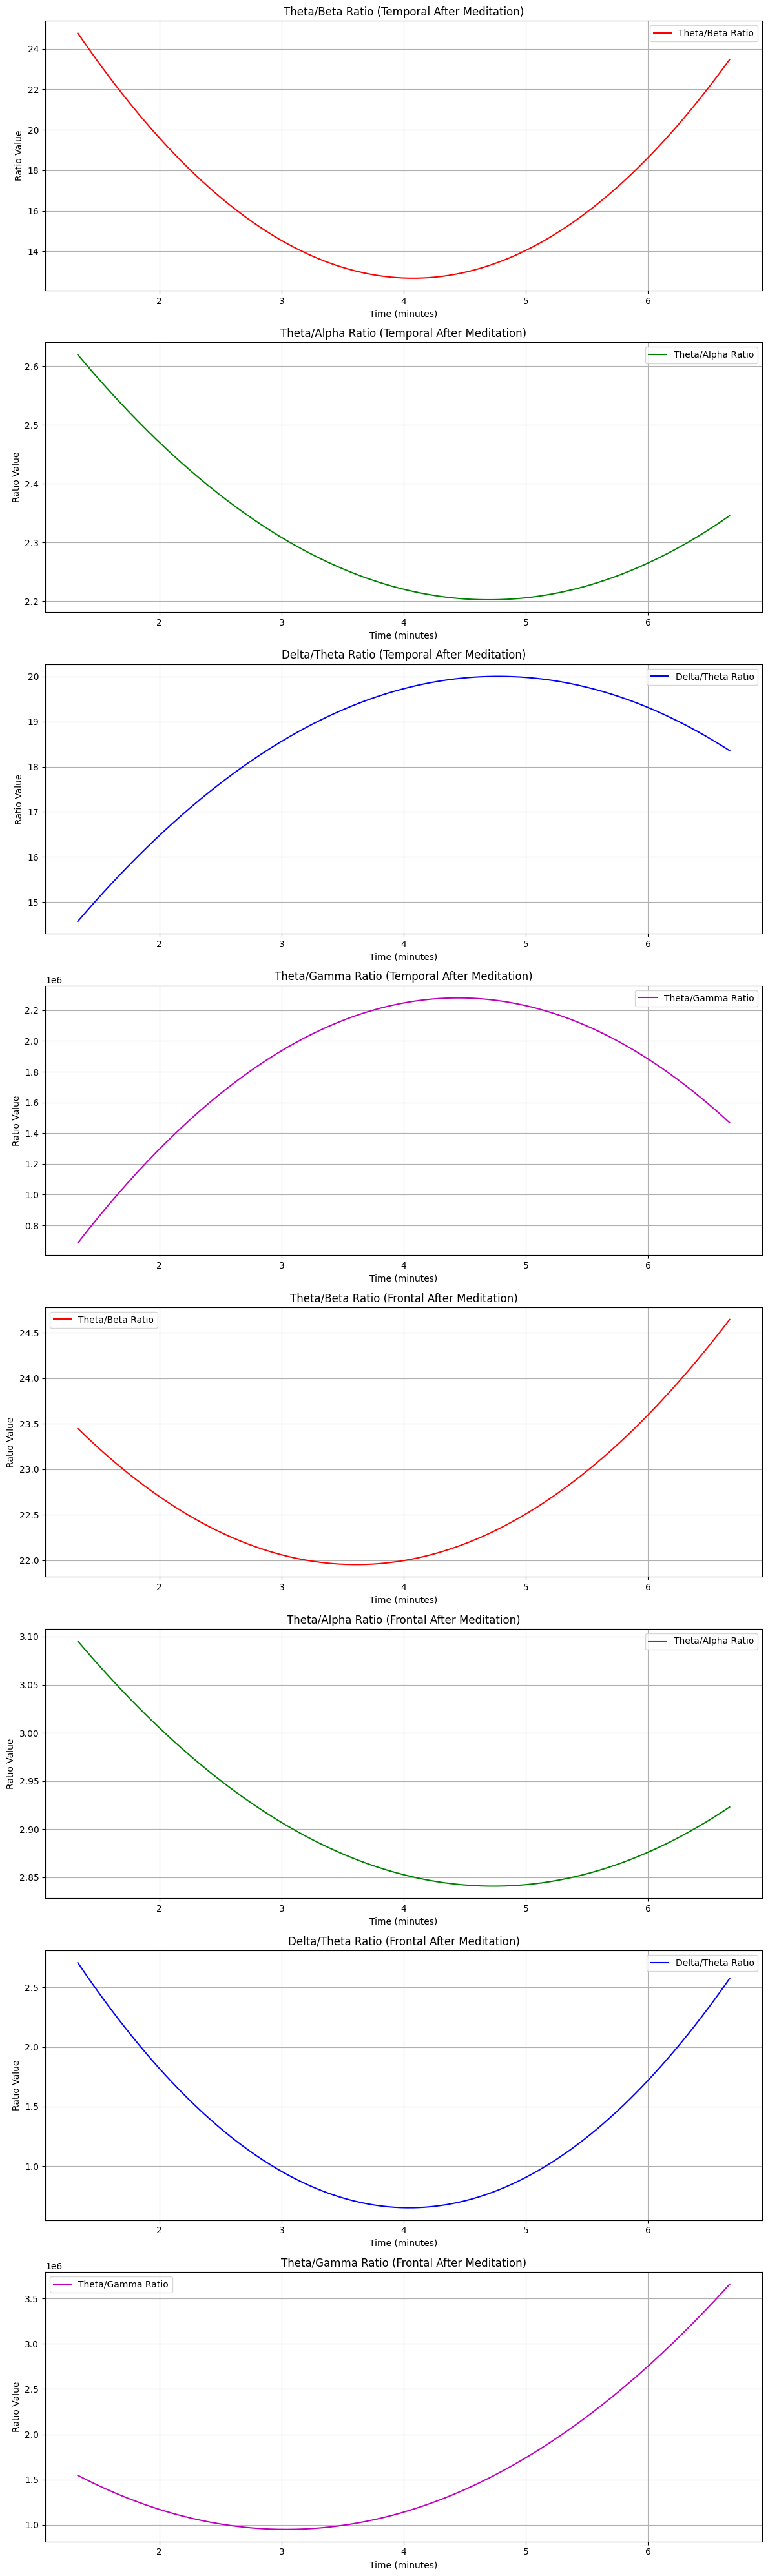

In [37]:
# All plots - frontal and temporal
# Define the xnew variable for interpolation
xnew = np.linspace(min(midpoints), max(midpoints), 300)

# Plotting separate curves for each ratio for temporal and frontal data
fig, axs = plt.subplots(8, 1, figsize=(12, 40))

# Temporal plotting
for idx, (ratio, color) in enumerate(zip(ratios, ['r', 'g', 'b', 'm'])):
    spline = make_interp_spline(midpoints, avg_data_temporal_after[ratio], k=2)
    ynew = spline(xnew)
    axs[idx].plot(xnew, ynew, label=ratio, color=color)
    axs[idx].set_title(ratio + " (Temporal After Meditation)")
    axs[idx].set_xlabel("Time (minutes)")
    axs[idx].set_ylabel("Ratio Value")
    axs[idx].legend()
    axs[idx].grid(True)

# Frontal plotting
for idx, (ratio, color) in enumerate(zip(ratios, ['r', 'g', 'b', 'm'])):
    spline = make_interp_spline(midpoints, avg_data_frontal_after[ratio], k=2)
    ynew = spline(xnew)
    axs[idx + 4].plot(xnew, ynew, label=ratio, color=color)
    axs[idx + 4].set_title(ratio + " (Frontal After Meditation)")
    axs[idx + 4].set_xlabel("Time (minutes)")
    axs[idx + 4].set_ylabel("Ratio Value")
    axs[idx + 4].legend()
    axs[idx + 4].grid(True)

plt.tight_layout()
plt.show()


In [38]:
# Combined table
# Calculate shifts for frontal and temporal data after meditation
shifts_frontal_after = {ratio: calculate_shift(avg_data_frontal_after[ratio]) for ratio in ratios}
shifts_temporal_after = {ratio: calculate_shift(avg_data_temporal_after[ratio]) for ratio in ratios}

# Prepare data for table for frontal and temporal regions
data_table_after = {
    'Brain Region': ['Frontal', 'Frontal', 'Temporal', 'Temporal'],
    'Stages': ['Second 30%', 'Third 30%', 'Second 30%', 'Third 30%'],
    'TBR': [shifts_frontal_after['Theta/Beta Ratio'][0], shifts_frontal_after['Theta/Beta Ratio'][1],
            shifts_temporal_after['Theta/Beta Ratio'][0], shifts_temporal_after['Theta/Beta Ratio'][1]],
    'TAR': [shifts_frontal_after['Theta/Alpha Ratio'][0], shifts_frontal_after['Theta/Alpha Ratio'][1],
            shifts_temporal_after['Theta/Alpha Ratio'][0], shifts_temporal_after['Theta/Alpha Ratio'][1]],
    'DTR': [shifts_frontal_after['Delta/Theta Ratio'][0], shifts_frontal_after['Delta/Theta Ratio'][1],
            shifts_temporal_after['Delta/Theta Ratio'][0], shifts_temporal_after['Delta/Theta Ratio'][1]],
    'TGR': [shifts_frontal_after['Theta/Gamma Ratio'][0], shifts_frontal_after['Theta/Gamma Ratio'][1],
            shifts_temporal_after['Theta/Gamma Ratio'][0], shifts_temporal_after['Theta/Gamma Ratio'][1]],
}

# Convert to DataFrame
df_shifts_after = pd.DataFrame(data_table_after)
df_shifts_after


,Brain Region,Stages,TBR,TAR,DTR,TGR
0,Frontal,Second 30%,-6.187834,-7.836863,-75.914660,-26.244899
1,Frontal,Third 30%,12.035336,2.464309,294.799533,220.573271
2,Temporal,Second 30%,-48.789186,-15.225643,35.373364,227.884255
3,Temporal,Third 30%,85.000968,5.631583,-6.957272,-34.681925
